In [1]:
import numpy as np
import os
import pandas as pandas
import PIL

from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout 
from keras.callbacks import ModelCheckpoint 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import model_from_json
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.per_process_gpu_memory_fraction=0.3
session = tf.Session(config=config)

In [3]:
from config import csv_config as config
hdf5_path = "../input/datasets/diabetes/diabetes_in.h5"

In [4]:
seed = 7
np.random.seed(seed)

In [5]:
from helpers import CSVDatasetReader
reader = CSVDatasetReader(hdf5_path)
(X, Y) = reader.load()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)   
y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

In [6]:
def model_deep():
    model = Sequential()
    model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(2, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
model_deep = model_deep()
model_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 26        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model_deep.fit(X_train, y_train, validation_split=0.33, epochs=30, batch_size=10, 
                         #callbacks=callbacks_list, 
                         verbose=0)
score = model_deep.evaluate(X_test, y_test, verbose=0)

In [9]:
print("%s: %.2f%%" % (model_deep.metrics_names[1], score[1]*100))

acc: 79.86%


In [10]:
def smooth_curve(points, factor=0.9): 
    smoothed_points = [] 
    for point in points: 
        if smoothed_points: 
            previous = smoothed_points[-1] 
            smoothed_points.append(previous * factor + point * (1 - factor)) 
        else: smoothed_points.append(point) 
    return smoothed_points

dict_keys(['val_acc', 'val_loss', 'loss', 'acc'])


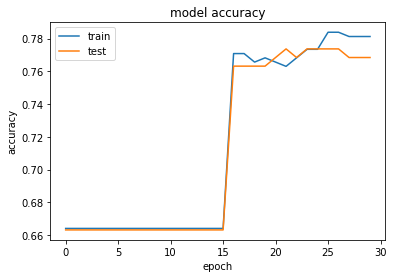

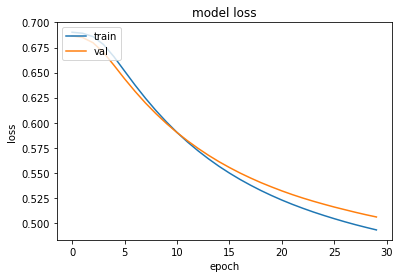

In [11]:
print(history.history.keys())

plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

plt.plot(smooth_curve(history.history['loss']))
plt.plot(smooth_curve(history.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
predicted = model_deep.predict_classes(X_test)
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.82      0.89      0.85        95
          1       0.75      0.61      0.67        49

avg / total       0.79      0.80      0.79       144



In [13]:
conf = confusion_matrix(y_test,predicted)

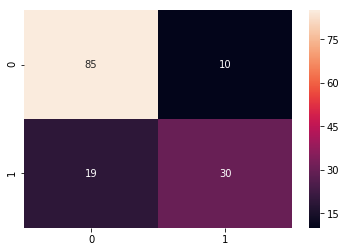

In [14]:
label = ["0","1"]
sns.heatmap(conf, annot=True, xticklabels=label, yticklabels=label)

In [15]:
df_test = pandas.DataFrame(X_test)
df_test["actual"] = y_test
df_test["predicted"] = predicted
incorrect = df_test[(df_test["actual"] != df_test["predicted"]) & (df_test["actual"])]
print(incorrect.index)

Int64Index([1, 6, 8, 13, 23, 34, 52, 58, 59, 61, 64, 90, 106, 108, 109, 112,
            122, 127, 132],
           dtype='int64')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FD603227B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001FD6A5BF6A0>]], dtype=object)

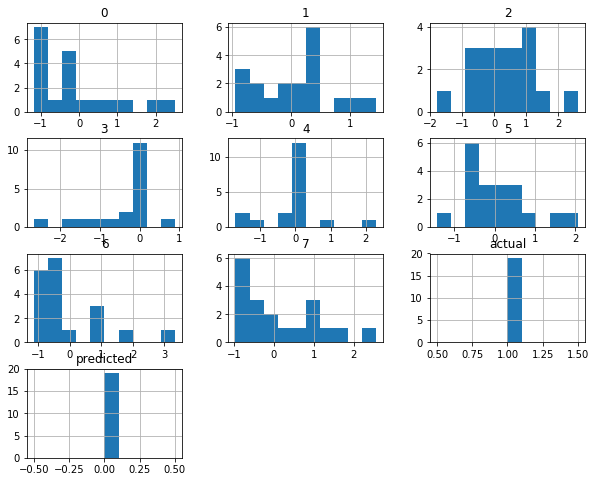

In [16]:
incorrect.hist(figsize=(10,8))

In [17]:
num_epochs = 30
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
all_scores = []
all_loss_histories = []
for train, test in kfold.split(X, Y):
    history = model_deep.fit(X[train], Y[train], epochs=num_epochs, batch_size=10, verbose=0)
    loss_history = history.history['loss']
    all_loss_histories.append(loss_history)
    # evaluate the model
    score = model_deep.evaluate(X[test], Y[test], verbose=0)
    all_scores.append(score[1]*100)

In [18]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(all_scores), np.std(all_scores)))

78.98% (+/- 4.23%)
